# XGBoost for Steering Classification

This notebook trains and evaluates XGBoost (Extreme Gradient Boosting) on the steering image dataset.

**Key Concepts:**
- Regularized gradient boosting (L2 penalty on tree coefficients)
- Engineering optimizations (parallel computing, quantile sketching)
- Handles missing values automatically
- Often achieves state-of-the-art performance


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [4]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=False
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=False
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}
Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 40 components
  Variance retained: 95.02%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. Hyperparameter Tuning


In [5]:
# Calculate class weights for XGBoost
from collections import Counter
class_counts = Counter(raw_processed['y_train'])
total = sum(class_counts.values())
n_classes = len(class_counts)
# Scale weights to give balanced treatment
scale_pos_weight = None  # For multi-class, use sample_weight instead

# Create sample weights for training
train_class_counts = Counter(raw_processed['y_train'])
sample_weights_raw = np.array([total / (n_classes * train_class_counts[y]) for y in raw_processed['y_train']])
sample_weights_eng = np.array([total / (n_classes * train_class_counts[y]) for y in eng_processed['y_train']])

print("Sample weights created to handle class imbalance")


Sample weights created to handle class imbalance


In [6]:
# Grid search for XGBoost on RAW features
print("Tuning XGBoost on RAW (PCA) features...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'reg_lambda': [0, 1, 10]  # L2 regularization
}

xgb_raw = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search_raw = GridSearchCV(
    xgb_raw, param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1
)
grid_search_raw.fit(raw_processed['X_train'], raw_processed['y_train'], sample_weight=sample_weights_raw)

print(f"\nBest parameters: {grid_search_raw.best_params_}")
print(f"Best CV F1 score: {grid_search_raw.best_score_:.4f}")


Tuning XGBoost on RAW (PCA) features...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.8}
Best CV F1 score: 0.9163


In [7]:
# Grid search for XGBoost on ENGINEERED features
print("Tuning XGBoost on ENGINEERED features...")

grid_search_eng = GridSearchCV(
    XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', 
                  use_label_encoder=False, random_state=RANDOM_STATE, n_jobs=-1),
    param_grid, cv=skf, scoring='f1_macro', n_jobs=-1, verbose=1
)
grid_search_eng.fit(eng_processed['X_train'], eng_processed['y_train'], sample_weight=sample_weights_eng)

print(f"\nBest parameters: {grid_search_eng.best_params_}")
print(f"Best CV F1 score: {grid_search_eng.best_score_:.4f}")


Tuning XGBoost on ENGINEERED features...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 10, 'subsample': 0.8}
Best CV F1 score: 0.8885


## 3. Evaluate Best Models


Evaluating best XGBoost on RAW (PCA) features...

Model: XGBoost | Features: raw
Accuracy:          0.9061
Balanced Accuracy: 0.9159
Macro F1:          0.8686
Weighted F1:       0.9087
Macro Precision:   0.8324
Macro Recall:      0.9159
ROC-AUC (macro):   0.9818

Per-class metrics:
  forward   : F1=0.9344, Precision=0.9700, Recall=0.9013
  left      : F1=0.8322, Precision=0.7662, Recall=0.9105
  right     : F1=0.8393, Precision=0.7609, Recall=0.9358

Classification Report:
              precision    recall  f1-score   support

     forward       0.97      0.90      0.93      1469
        left       0.77      0.91      0.83       324
       right       0.76      0.94      0.84       187

    accuracy                           0.91      1980
   macro avg       0.83      0.92      0.87      1980
weighted avg       0.92      0.91      0.91      1980



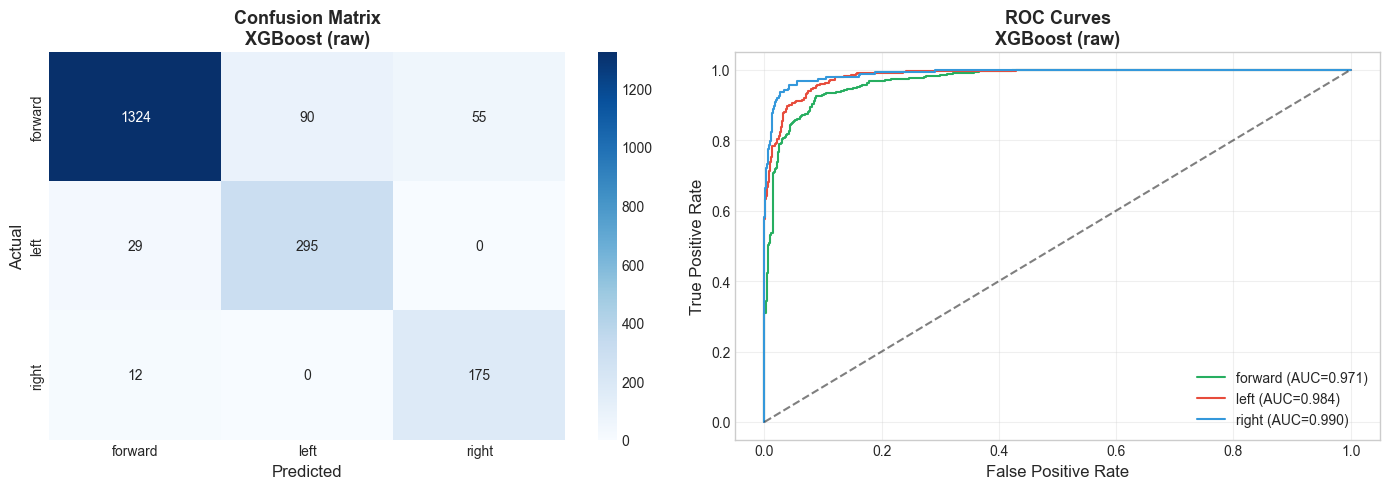

In [8]:
# Evaluate best model on RAW features
print("Evaluating best XGBoost on RAW (PCA) features...")

best_xgb_raw = grid_search_raw.best_estimator_

results_xgb_raw = evaluate_model(
    best_xgb_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='XGBoost',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Evaluating best XGBoost on ENGINEERED features...

Model: XGBoost | Features: engineered
Accuracy:          0.8727
Balanced Accuracy: 0.8843
Macro F1:          0.8239
Weighted F1:       0.8773
Macro Precision:   0.7821
Macro Recall:      0.8843
ROC-AUC (macro):   0.9680

Per-class metrics:
  forward   : F1=0.9099, Precision=0.9579, Recall=0.8666
  left      : F1=0.7901, Precision=0.7150, Recall=0.8827
  right     : F1=0.7717, Precision=0.6733, Recall=0.9037

Classification Report:
              precision    recall  f1-score   support

     forward       0.96      0.87      0.91      1469
        left       0.71      0.88      0.79       324
       right       0.67      0.90      0.77       187

    accuracy                           0.87      1980
   macro avg       0.78      0.88      0.82      1980
weighted avg       0.89      0.87      0.88      1980



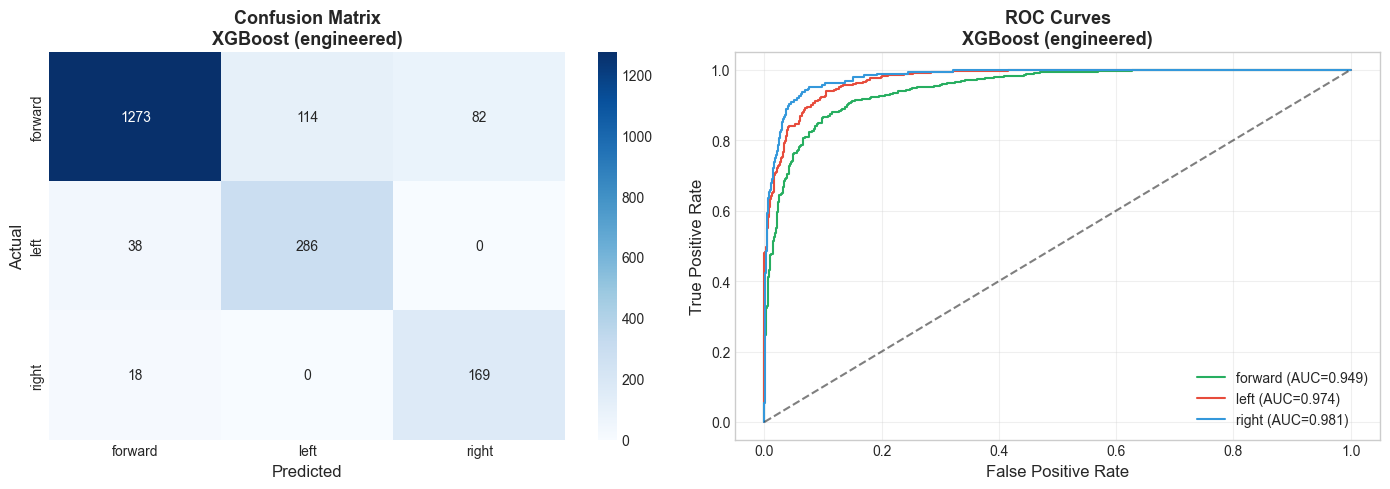

In [9]:
# Evaluate best model on ENGINEERED features
print("Evaluating best XGBoost on ENGINEERED features...")

best_xgb_eng = grid_search_eng.best_estimator_

results_xgb_eng = evaluate_model(
    best_xgb_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='XGBoost',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 4. Feature Importance


Feature Importance (Engineered Features):
   1. brightness_center_x      : 0.2257
   2. quad_bl_mean             : 0.1144
   3. lr_asymmetry             : 0.0796
   4. skewness                 : 0.0647
   5. iqr                      : 0.0417
   6. lr_ratio                 : 0.0411
   7. tb_diff                  : 0.0399
   8. quad_br_mean             : 0.0392
   9. diag_asymmetry           : 0.0291
  10. intensity_mean           : 0.0200
  11. kurtosis                 : 0.0191
  12. percentile_90            : 0.0176
  13. edge_hv_ratio            : 0.0176
  14. quad_tr_mean             : 0.0169
  15. edge_mean                : 0.0154


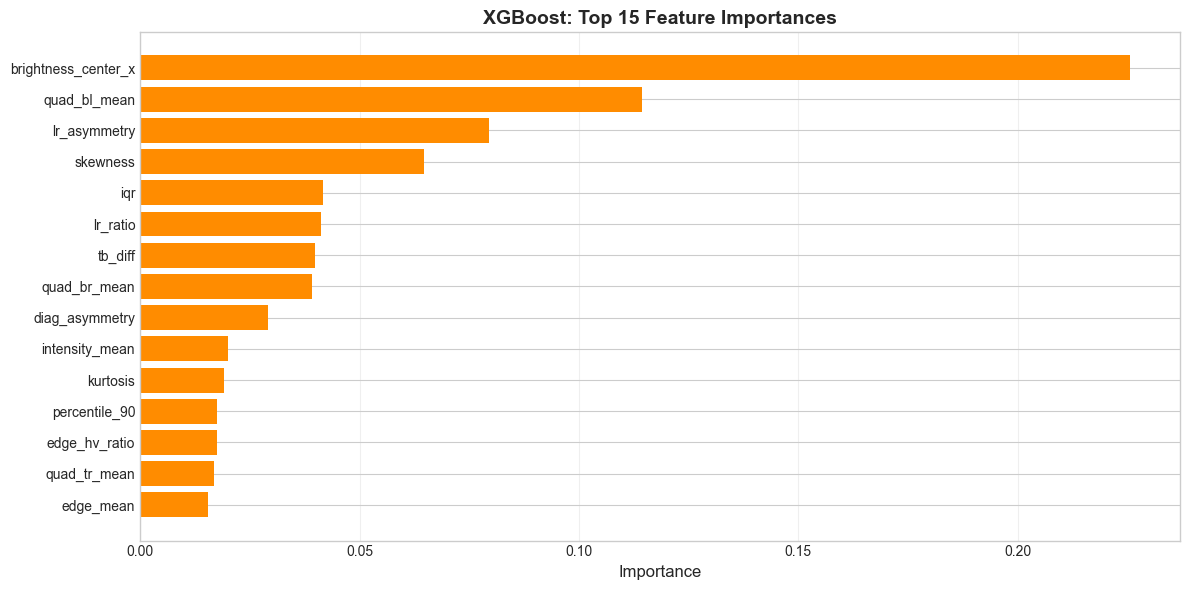

In [10]:
# Feature importance for engineered features
print("Feature Importance (Engineered Features):")
print("="*50)

importances = best_xgb_eng.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(min(15, len(feature_names))):
    idx = indices[i]
    print(f"  {i+1:2d}. {feature_names[idx]:25s}: {importances[idx]:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))
top_n = 15
top_indices = indices[:top_n]

ax.barh(range(top_n), importances[top_indices], color='darkorange')
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in top_indices])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('XGBoost: Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 5. Results Summary


In [11]:
# Summary
all_results = [results_xgb_raw, results_xgb_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("XGBOOST RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



XGBOOST RESULTS SUMMARY
  Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
XGBoost        raw  0.906061      0.915872    0.868618 0.981808
XGBoost engineered  0.872727      0.884345    0.823893 0.968032


In [12]:
# Save results
save_results(all_results, 'xgboost')
print("Results saved successfully!")


Results saved to ../../data/model_results/xgboost_results.json
Results saved successfully!


## 6. Key Observations

### XGBoost Improvements over MART
- **Regularization**: L2 penalty on tree coefficients (reg_lambda)
- **Engineering**: Parallel computing, quantile sketching for faster training
- **Pruning**: Can prune trees via gain threshold

### Tuning Parameters
- `n_estimators`: Number of boosting rounds
- `max_depth`: Tree depth (usually 3-10)
- `learning_rate`: Shrinkage (smaller = more iterations needed)
- `reg_lambda`: L2 regularization strength
- `subsample`: Fraction of samples for each tree

### Performance
- Often achieves state-of-the-art on structured/tabular data
- Handles class imbalance via sample weights
- Scales well to large datasets
